In [1]:
# Importing all the required modules
import tensorrt as trt
import onnx
import torch
import numpy as np
import time
import torchvision
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F
import pycuda.driver as cuda
import pycuda.autoinit
from PIL import Image
import matplotlib.pyplot as plt

### Step 1: Convert the model to ONNX format

In [2]:
# Load the pretrained ResNet-50 model from torchvision library
model_resnet_50 = models.resnet50(pretrained=True)
model_resnet_50.eval()

/home/lkondap/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lkondap/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
# This block creates a dummy input and exports the model to ONNX
input_shape = (3,224,224)

dummy_input = torch.randn(1, *input_shape) # 1 here represents batch_size

# Exporting the model to ONNX
torch.onnx.export(model_resnet_50, dummy_input, "resnet_50.onnx", verbose=False)

# Notes: Setting the verbose to True is making the export run a lot slower

### Step 2: Optimize ONNX model with TensorRT

In [4]:
# Load the exported ONNX model
onnx_model = onnx.load("resnet_50.onnx")

# Create a TensorRT builder and network
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
builder = trt.Builder(TRT_LOGGER)
network = builder.create_network(0) # Notes 
config = builder.create_builder_config()
parser = trt.OnnxParser(network, TRT_LOGGER)
#builder.max_DLA_batch_size = 1
config.set_flag(trt.BuilderFlag.FP16)
config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 1 << 30)

# Parse the ONNX model
success = parser.parse(onnx_model.SerializeToString())
if not success:
    for error in range(parser.num_errors):
        print(parser.get_error(error))
    exit()

# Build the TensorRT engine
engine = builder.build_serialized_network(network, config)

# Save the engine file
#with open("resnet_50.plan", "wb") as f:
#    f.write(engine)

#### Notes:
1. EXPLICIT_BATCH is deprecated as of TensorRT 10.0, otherwise an argument 1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH) needs to be passed to create_network
2. 

In [5]:
# Create a runtime
trt_runtime = trt.Runtime(TRT_LOGGER)
# Deserialize engine
deserialized_eng = trt_runtime.deserialize_cuda_engine(engine)

In [6]:
def allocate_buffers(engine: trt.ICudaEngine):
    inputs = []
    outputs = []
    # Get IO names
    tensor_names = [engine.get_tensor_name(i) for i in range(engine.num_io_tensors)]
    for binding in tensor_names:
        dtype = np.dtype(trt.nptype(engine.get_tensor_dtype(binding)))
        # Host memory
        hostMemory = cuda.pagelocked_empty(trt.volume(engine.get_tensor_shape(binding)), dtype = dtype)
        # Device memory
        deviceMemory = cuda.mem_alloc(hostMemory.nbytes)
        if engine.get_tensor_mode(binding) == trt.TensorIOMode.INPUT:
            inputs.append(hostMemory)
            inputs.append(deviceMemory)
        else:
            outputs.append(hostMemory)
            outputs.append(deviceMemory)
    # Create a stream for inference
    stream = cuda.Stream()
    return inputs, outputs, stream

In [7]:
input_memory, output_memory, stream = allocate_buffers(deserialized_eng)

In [8]:
def do_inference(engine, pics, input_mem, output_mem, stream, batch_size=1, width=1000):
    preprocessed = np.asarray(pics).ravel()
    # Copy data to host page-locked memory
    np.copyto(input_mem[0], preprocessed)
    # Create a execution context
    with engine.create_execution_context() as context:
        # Transfer input data to the device
        cuda.memcpy_htod_async(input_mem[1], input_mem[0], stream)
        # Synchornously execute inference 
        context.execute_v2(bindings=[int(input_mem[1]), int(output_mem[1])])
        # Transfer predictions from device to host
        cuda.memcpy_dtoh_async(output_mem[0], output_mem[1], stream)
        # Synchronize the stream
        stream.synchronize()
        # Return the host output
        out = output_mem[0].reshape((batch_size, 1, width))
        return out

In [9]:
# ImageNet labels
!wget  -O ./imagenet_class_index.json "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"

--2024-04-09 17:02:06--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.166.56, 52.217.227.168, 52.217.46.254, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.166.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘./imagenet_class_index.json’

./imagenet_class_in 100%[===================>]  34.53K  --.-KB/s    in 0.02s   

2024-04-09 17:02:06 (1.92 MB/s) - ‘./imagenet_class_index.json’ saved [35363/35363]



In [10]:
import json
# Load labels
with open("./imagenet_class_index.json") as json_file: 
    classes_file = json.load(json_file)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


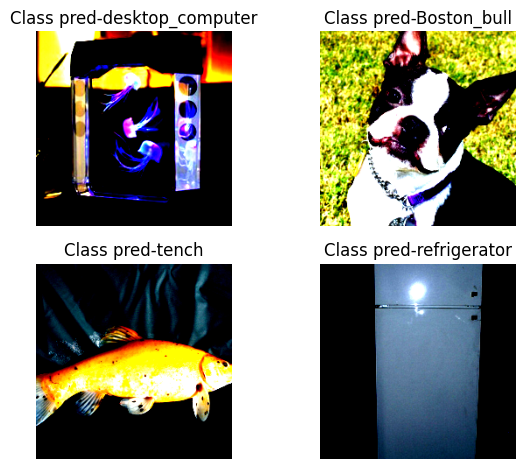

In [11]:
import os
image_list = os.listdir('sample_images/')
fig, axes = plt.subplots(nrows=2, ncols=2)
i=0
image_batch = []
for image_file in image_list:
    if image_file.endswith('.JPEG'):
        image = Image.open('sample_images/' +image_file)
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        # Pre-process the images based on ResNet-50 architecture
        image = preprocess(image)
        # Run inference on test images
        output_pred = do_inference(deserialized_eng, image, input_memory, output_memory, stream)
        # Get the class name of the predicted class
        pred_class = classes_file[str(np.argmax(output_pred))]
        ax = plt.subplot(2,2,i+1)
        ax.set_title('Class pred-' + pred_class[1])
        plt.imshow(image.permute(1,2,0))
        plt.axis('off')
        i+=1

plt.tight_layout()
plt.show()

In [12]:
# Free up the memory buffers
def free_buffers(inputs, outputs, stream):
    for host_mem, device_mem in [inputs, outputs]:
        device_mem.free()
    stream.synchronize()

In [13]:
free_buffers(input_memory, output_memory, stream)